In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Read in 
df10 = pd.read_csv('../data/df10.csv')

In [3]:
# Inspect
df10

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.611402,0.720283,3.165168,0.372100,-0.360194,6.417779,A2,B3,C16,D1,-16.680112
1,-0.463374,-0.908280,3.046919,0.866590,0.949304,6.142320,A1,B2,C6,D3,-0.347247
2,-0.004264,-2.710478,3.629876,0.587660,-0.413790,7.196720,A2,B1,C10,D3,-13.192616
3,0.310406,-0.511657,3.269785,3.036609,-0.430169,6.363889,A2,B5,C33,D2,0.764504
4,-2.537362,0.594968,1.731083,0.616347,1.753629,3.273066,A1,B1,C6,D3,1.757865
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.786519,-0.053336,4.551310,0.503011,-0.332187,8.955659,A2,B4,C48,D2,-5.785166
9996,-3.341972,-0.603921,2.693938,-0.788320,-0.766215,5.303121,A1,B5,C24,D2,19.692702
9997,-0.409354,0.337466,3.140098,-1.672133,-0.235241,5.997826,A1,B1,C32,D3,-0.011697
9998,-2.129938,-0.588379,3.735092,-0.368141,1.876631,7.281910,A2,B1,C16,D3,-17.691367


# First attempt

- Ignore x9
- 60/20/20 train/test/holdout [6k/2k/2k rows]
- Within train, 6-fold cross-validation to optimize hyperparameters:
    - `max_depth` = 2-8
    - `max_features` = 'auto', 'sqrt', 'log2'
    - `subsample` = 0.5, 0.67, 0.75
    - Static parameters
        - `n_estimators` = 1k
        - `validation_fraction` = 0.2
        - `n_iter_no_change` = 1
        - `tol` = 1e-4
        
Also, will not include x3 and x6 because they were not found to have much relationship with y.

In [4]:
# Train/test/holdout vars
p_train = 0.6
p_test = 0.2
p_test_relative = p_test / (p_train + p_test)
p_holdout = 0.2
k_folds = 6

# Static hyperparameters
s_n_estimators = 1000
s_validation_fraction = 0.2
s_n_iter_no_change = 1
s_tol = 1e-4

# Lists of hyperparameters to optimize
l_max_depth = [2, 3, 4, 5, 6, 7, 8]
l_max_features = ['auto', 'sqrt', 'log2']
l_subsample = [0.5, 0.67, 0.75]

In [5]:
# Add some x2 predictors
df10['x2_abs'] = abs(df10['x2'])
df10['x2_sign'] = np.sign(df10['x2'])

# Create X/y
predictors_1 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df10[predictors_1], prefix=['x7', 'x8', 'x10']), df10['y']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 16)
Test: (2000, 16)
Holdout: (2000, 16)



In [6]:
# Set random seed for everything that follows
np.random.seed(666)

In [7]:
# How many iterations of cross-validation?
hp_sets = list(product(l_max_depth, l_max_features, l_subsample))

len(hp_sets)

63

In [8]:
scores_1 = []
for md, mf, ss in hp_sets:
    # Print status
    print(f'Fitting max_depth={md}, max_features={mf}, subsample={ss}')
    
    # Initialize gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = md,
        max_features = mf,
        subsample = ss,
    )

    # Get scores
    cv_score = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv = k_folds,
        scoring = 'neg_mean_squared_error',
    ) 

    # Save the score means and standard deviations
    for i, k in enumerate(cv_score):
        scores_1 += [((md, mf, ss), i, k, np.mean(cv_score))]
    
    del gbm, cv_score

Fitting max_depth=2, max_features=auto, subsample=0.5
Fitting max_depth=2, max_features=auto, subsample=0.67
Fitting max_depth=2, max_features=auto, subsample=0.75
Fitting max_depth=2, max_features=sqrt, subsample=0.5
Fitting max_depth=2, max_features=sqrt, subsample=0.67
Fitting max_depth=2, max_features=sqrt, subsample=0.75
Fitting max_depth=2, max_features=log2, subsample=0.5
Fitting max_depth=2, max_features=log2, subsample=0.67
Fitting max_depth=2, max_features=log2, subsample=0.75
Fitting max_depth=3, max_features=auto, subsample=0.5
Fitting max_depth=3, max_features=auto, subsample=0.67
Fitting max_depth=3, max_features=auto, subsample=0.75
Fitting max_depth=3, max_features=sqrt, subsample=0.5
Fitting max_depth=3, max_features=sqrt, subsample=0.67
Fitting max_depth=3, max_features=sqrt, subsample=0.75
Fitting max_depth=3, max_features=log2, subsample=0.5
Fitting max_depth=3, max_features=log2, subsample=0.67
Fitting max_depth=3, max_features=log2, subsample=0.75
Fitting max_dept

In [9]:
# Save results as a dataframe
scores_1_df = pd.DataFrame(
    scores_1,
    columns = ['hp', 'k', 'score_k', 'score_hp_mean']
)

# Order by score_hp_mean and k
scores_1_df = scores_1_df.sort_values(['score_hp_mean', 'k'], ascending=[False, True]).reset_index()

scores_1_df.head(20)

,index,hp,k,score_k,score_hp_mean
0,54,"(3, auto, 0.5)",0,-58.767970,-61.442002
1,55,"(3, auto, 0.5)",1,-60.447642,-61.442002
2,56,"(3, auto, 0.5)",2,-62.722003,-61.442002
3,57,"(3, auto, 0.5)",3,-59.750933,-61.442002
4,58,"(3, auto, 0.5)",4,-64.310454,-61.442002
5,59,"(3, auto, 0.5)",5,-62.653007,-61.442002
6,120,"(4, auto, 0.75)",0,-58.105505,-61.562716
7,121,"(4, auto, 0.75)",1,-59.772739,-61.562716
8,122,"(4, auto, 0.75)",2,-63.162058,-61.562716
9,123,"(4, auto, 0.75)",3,-58.412828,-61.562716


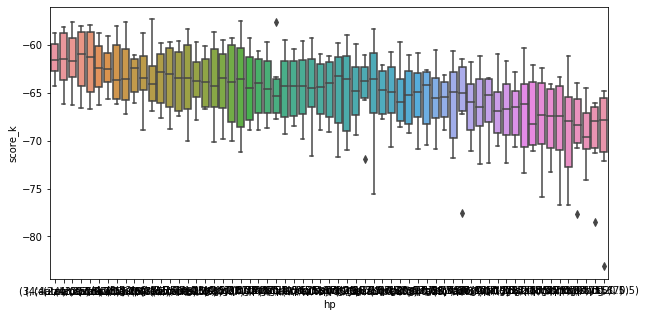

In [10]:
# Boxplot of performance for each parameter set
plt.figure(figsize=(10, 5))
sb.boxplot(
    data = scores_1_df,
    x = 'hp',
    y = 'score_k',
)

In [11]:
# Hyperparameter sets in order
scores_1_df.hp.unique()

array([(3, 'auto', 0.5), (4, 'auto', 0.75), (4, 'auto', 0.67),
       (2, 'auto', 0.75), (4, 'auto', 0.5), (3, 'auto', 0.67),
       (3, 'auto', 0.75), (2, 'auto', 0.67), (4, 'log2', 0.5),
       (2, 'auto', 0.5), (3, 'sqrt', 0.75), (5, 'sqrt', 0.75),
       (6, 'auto', 0.5), (5, 'auto', 0.75), (6, 'auto', 0.75),
       (5, 'auto', 0.5), (5, 'log2', 0.67), (6, 'auto', 0.67),
       (4, 'log2', 0.67), (4, 'log2', 0.75), (3, 'log2', 0.67),
       (4, 'sqrt', 0.67), (5, 'log2', 0.5), (3, 'sqrt', 0.5),
       (6, 'log2', 0.5), (3, 'log2', 0.5), (4, 'sqrt', 0.75),
       (7, 'auto', 0.5), (3, 'sqrt', 0.67), (4, 'sqrt', 0.5),
       (7, 'auto', 0.75), (6, 'sqrt', 0.5), (5, 'sqrt', 0.67),
       (5, 'log2', 0.75), (6, 'log2', 0.67), (3, 'log2', 0.75),
       (5, 'auto', 0.67), (8, 'auto', 0.5), (6, 'sqrt', 0.67),
       (2, 'log2', 0.67), (7, 'auto', 0.67), (6, 'log2', 0.75),
       (6, 'sqrt', 0.75), (7, 'log2', 0.67), (8, 'auto', 0.67),
       (7, 'sqrt', 0.67), (5, 'sqrt', 0.5), (8, 'auto'

Quite a few of the unique combinations at the beginning are very similar and have rather similar distributional behavior in the boxplot.  In absense of a clear winner, let's proceed with the following parameter sets to provide some variety in models that may fit well on the test set.

- (3, 'auto', 0.5)  # Best overall performance
- (4, 'auto', 0.75)  # Best 4 depth performance
- (2, 'auto', 0.75)  # Best 2 depth performance
- (6, 'auto', 0.5)  # Best 6 depth performance
- (4, 'log2', 0.5)  # Best log2 performance
- (3, 'sqrt', 0.75)  # Best sqrt performance

In [12]:
# Fit new models on whole training data set
best_hp_sets = [
    (3, 'auto', 0.5),
    (4, 'auto', 0.75),
    (2, 'auto', 0.75),
    (6, 'auto', 0.5),
    (4, 'log2', 0.5),
    (3, 'sqrt', 0.75),
]
models_train_1 = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X_train, y_train)
    
    # Save predictions
    models_train_1[hp] = {
        'model': gbm,
        'train_err': y_train - gbm.predict(X_train),
        'test_err': y_test - gbm.predict(X_test)
    }
    
    del gbm

Fitting (3, 'auto', 0.5)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         193.8273          23.6282            5.99s
         2         174.5759          18.0584            5.49s
         3         154.7038          15.9782            5.32s
         4         142.3474          13.2838            5.23s
         5         121.6135          10.8358            5.17s
         6         121.0939           7.9826            4.97s
         7         110.6244           7.1636            4.97s
         8         110.5274           5.8996            4.96s
         9         100.7621           4.8021            4.85s
        10          99.4296           4.2763            4.85s
        20          75.4519           0.9234            4.61s
        30          64.8321           0.6094            4.53s
        40          62.8841           0.2072            5.83s
        50          58.0436           0.0773            5.49s
        60          55.8973           0.0633

In [13]:
# Inspect one model
models_train_1[best_hp_sets[0]]

{'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=1, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.2, verbose=1, warm_start=False),
 'train_err': 7820     9.672609
 5815     9.543877
 7309     1.267136
 7163     8.463699
 2674     3.448749
           ...    
 9907     3.579428
 485     10.282737
 264     -3.273636
 8577     9.489622
 6415    -6.455033
 Name: y, Length: 6000, dtype: float64,
 'test_err': 369      3.297786
 2608     7.890276
 28

In [14]:
# Compare average mean squared errors
def amse(err):
    return (err ** 2).sum() / len(err)

for hp in best_hp_sets:
    print(f'''{hp}
    Train error: {amse(models_train_1[hp]['train_err'])}
    Test error: {amse(models_train_1[hp]['test_err'])}
    ''')

(3, 'auto', 0.5)
    Train error: 55.85550998414562
    Test error: 61.00050293780984
    
(4, 'auto', 0.75)
    Train error: 54.67761893971596
    Test error: 61.89817815684133
    
(2, 'auto', 0.75)
    Train error: 59.10038609290541
    Test error: 61.51941030646799
    
(6, 'auto', 0.5)
    Train error: 49.89897269536989
    Test error: 63.25383654655704
    
(4, 'log2', 0.5)
    Train error: 55.86745600893135
    Test error: 63.82775123164213
    
(3, 'sqrt', 0.75)
    Train error: 57.54332592430789
    Test error: 62.68087445771355
    


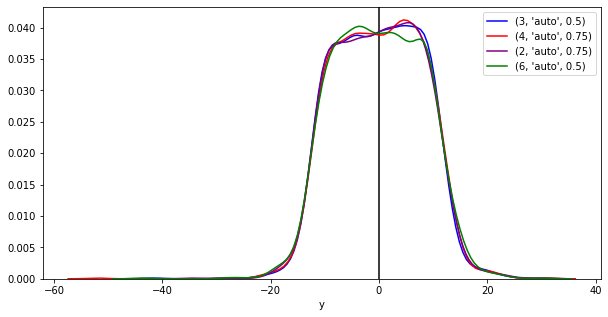

In [15]:
# Plot error distributions on test data for the better models
plt.figure(figsize=(10, 5))
plt.axvline(0, color='black')
colors = ['blue', 'red', 'purple', 'green']
models_to_plot = best_hp_sets[:4]
for i, hp in enumerate(models_to_plot):
    sb.distplot(models_train_1[hp]['test_err'], hist=False, color=colors[i], label=hp)

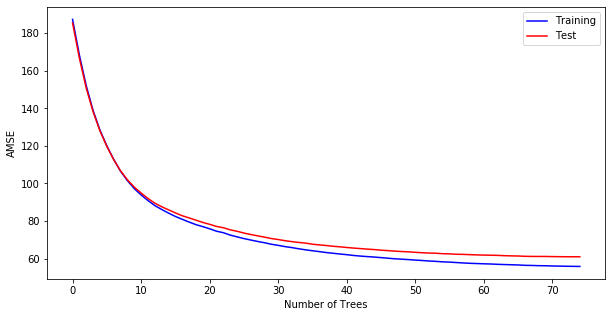

In [16]:
# Learning curves
def plot_lc(model):
    lc_train = [amse(y_train - x) for x in models_train_1[model]['model'].staged_predict(X_train)]
    lc_test = [amse(y_test - x) for x in models_train_1[model]['model'].staged_predict(X_test)]
    lc_x = list(range(len(lc_train)))

    plt.figure(figsize=(10, 5))
    sb.lineplot(x=lc_x, y=lc_train, color='blue', label='Training')
    sb.lineplot(x=lc_x, y=lc_test, color='red', label='Test')
    plt.xlabel('Number of Trees')
    plt.ylabel('AMSE')

# "Best" model
plot_lc(best_hp_sets[0])

All of the 'auto' models look similar on the test data but have rather different performance on the training data.

We'll gloss over that for now to see how x9 changes things.

# Now incorporate x9

x9 presents a unique problem with cross-validation.

Say we wanted to replace x9 with its group average.  If we use the averages over the **whole** training set, we introduce signal leakage in the folds being held out for test predictions (i.e. we're using the target variable in folds we're trying to predict to create predictors).  So if we really wanted to pair that with cross-validation to estimate hyperparameters we need to write custom code to derive that new `x9_group_mean` variable separately for each of the k iterations before fitting.  Which is possible but didn't want to go through that process here.

For simplicity, let's say we feel comfortable assuming that we only need to consider our current "best" sets of hyperparameters and evaluate using train/test splitting (i.e. use `hp_sets`).

In [17]:
# Get group means on training data
dict_x9_means = df10.iloc[X_train.index].groupby('x9').agg(y_mean=('y', 'mean'))['y_mean'].to_dict()
dict_x9_means

{'C0': -12.550545491454224,
 'C1': -9.252183967097219,
 'C10': -11.874918948335889,
 'C11': -8.63342443235809,
 'C12': -3.2905650551499805,
 'C13': 2.6235323895338065,
 'C14': 6.946319618866108,
 'C15': -13.182659212196892,
 'C16': -10.152773274469075,
 'C17': -3.4395587673656705,
 'C18': 3.3170700477142803,
 'C19': 7.075608381198373,
 'C2': -3.5889660458730774,
 'C20': -13.916275105691916,
 'C21': -8.31959324621824,
 'C22': -4.135303059457785,
 'C23': 2.9709295700649276,
 'C24': 5.9591054131246795,
 'C25': -14.32246506863715,
 'C26': -7.906035950428199,
 'C27': -2.6114647009541208,
 'C28': 1.1181376879798735,
 'C29': 7.722661411636184,
 'C3': 1.0857749609042813,
 'C30': -11.426574875982407,
 'C31': -6.398988853074895,
 'C32': -1.6113243931614731,
 'C33': 0.5515965167014896,
 'C34': 6.564164642448199,
 'C35': -14.71709847484338,
 'C36': -7.765675422905011,
 'C37': -3.3844724541610676,
 'C38': 2.806667202987631,
 'C39': 6.052058720698373,
 'C4': 6.667386127185435,
 'C40': -14.1253108475

In [18]:
# Add some x2 predictors
df10['x9_group_mean'] = df10['x9'].map(dict_x9_means)

# Create X/y
predictors_2 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x9_group_mean', 'x10']
X, y = pd.get_dummies(df10[predictors_2], prefix=['x7', 'x8', 'x10']), df10['y']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 17)
Test: (2000, 17)
Holdout: (2000, 17)



In [19]:
# Fit new models on whole training data set
models_train_2 = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X_train, y_train)
    
    # Save predictions
    models_train_2[hp] = {
        'model': gbm,
        'train_err': y_train - gbm.predict(X_train),
        'test_err': y_test - gbm.predict(X_test)
    }
    
    del gbm

Fitting (3, 'auto', 0.5)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         184.8052          26.0784            5.00s
         2         166.2424          22.5922            5.49s
         3         142.6964          18.4610            5.32s
         4         132.2905          15.4993            5.23s
         5         118.6902          12.5769            5.17s
         6         105.2398          10.9880            5.14s
         7          90.2852           9.2608            4.97s
         8          80.3695           7.8219            4.96s
         9          82.6819           5.5383            4.96s
        10          74.2277           6.2037            4.95s
        20          40.1889           1.7613            4.80s
        30          29.2698           0.8867            4.69s
        40          22.0997           0.3947            4.63s
        50          16.9878           0.1896            4.58s
        60          12.9308           0.1689

In [20]:
# Compare average mean squared errors
for hp in best_hp_sets:
    print(f'''{hp}
    Train error: {amse(models_train_2[hp]['train_err'])}
    Test error: {amse(models_train_2[hp]['test_err'])}
    ''')

(3, 'auto', 0.5)
    Train error: 8.703520684750925
    Test error: 10.829724668373245
    
(4, 'auto', 0.75)
    Train error: 7.521834247141668
    Test error: 10.940467446104144
    
(2, 'auto', 0.75)
    Train error: 10.411193100825082
    Test error: 11.86420199966372
    
(6, 'auto', 0.5)
    Train error: 8.407072583927029
    Test error: 12.291085278012579
    
(4, 'log2', 0.5)
    Train error: 9.471611670116214
    Test error: 12.918625005941681
    
(3, 'sqrt', 0.75)
    Train error: 9.942241661585951
    Test error: 12.563745167567566
    


Best fit on test seems to be (3, 'auto', 0.5), even though it doesn't have the lowest training error and doesn't look better by much (10.8 versus 10.9 for the next best).

My initial suspicion is that the training error is low on (6, 'auto', 0.5) due to overfitting on the training data.  Probably because we aren't using any type of tree regularization (e.g. pruning, requiring a certain sample size) to simplify the trees that get built.

### Plot univariates to see if any other sort of modification might improve model fit

In [21]:
def plot_univariate(df, x, y, filter_x7=None, model_fit=models_train_2[best_hp_sets[0]], n_bins=10):
    # Create copy of dataframe
    df = df.copy()
    
    # Subset to test rows
    df = df.iloc[X_test.index]
    
    # Add prediction
    df = df.assign(p = model_fit['model'].predict(X_test))
    
    # Apply filter_x7
    if filter_x7:
        df = df[df10.x7 == filter_x7]
    
    # If x is numeric, bin into groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1    n     y_mean       y_sd    p_mean       p_sd
0  (-3.349, -2.656]   14 -10.483115  15.085686 -9.254707  14.350153
1  (-2.656, -1.971]   40  -5.783603  12.650469 -4.954046  11.616450
2  (-1.971, -1.285]  121  -4.694796  14.911796 -4.586458  14.478559
3  (-1.285, -0.599]  361  -2.241680  14.686556 -2.167567  13.723625
4  (-0.599, 0.0864]  531  -0.921520  14.677675 -1.473981  13.960364
5   (0.0864, 0.772]  479  -5.907316  13.252324 -5.773941  12.280966
6    (0.772, 1.458]  303  -5.421904  15.098284 -5.131359  14.163994
7    (1.458, 2.143]  114  -4.513584  13.897776 -4.427469  13.189477
8    (2.143, 2.829]   32  -3.624521  13.091653 -3.172135  12.563339
9    (2.829, 3.515]    5   3.827210  15.228232  4.299056  14.127327


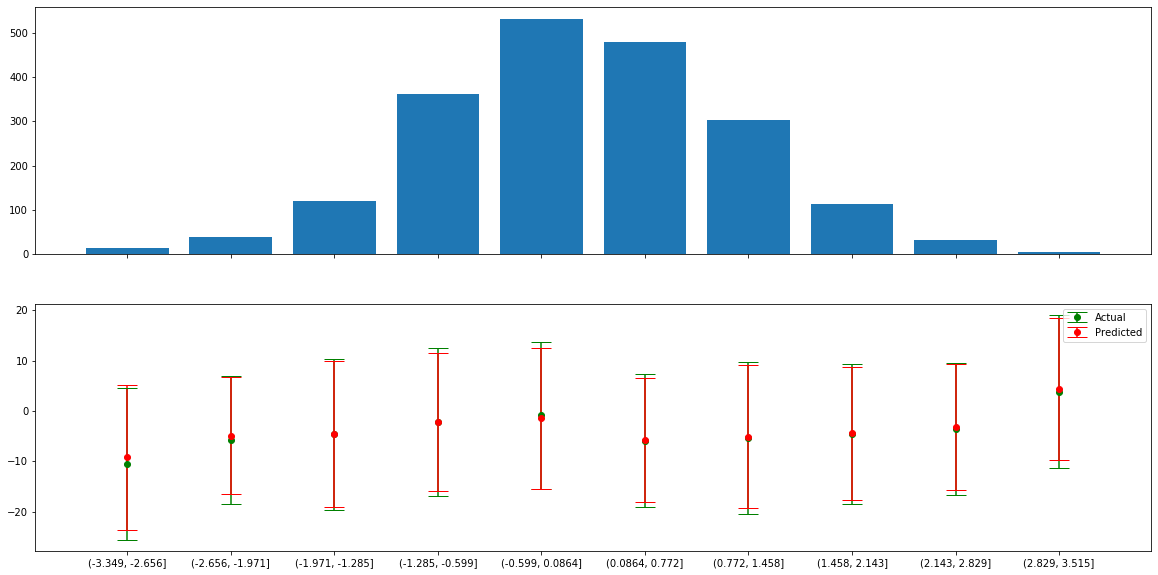

In [22]:
# x1
plot_univariate(df10, 'x1', 'y')

                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.279, -2.595]   11 -8.963161   8.915807 -8.882874   9.977144
1  (-2.595, -1.917]   51 -2.583432   9.656766 -2.712373  10.157666
2   (-1.917, -1.24]  148 -3.944287  12.748935 -4.062307  12.694058
3   (-1.24, -0.562]  324 -3.311579  16.481169 -3.101425  15.256426
4   (-0.562, 0.115]  516 -3.096149  15.152012 -3.139425  13.846404
5    (0.115, 0.793]  502 -4.007994  14.113056 -3.958108  13.084485
6    (0.793, 1.471]  308 -3.565381  13.985441 -3.785707  13.443933
7    (1.471, 2.148]  105 -6.141877  13.036458 -6.086238  13.317610
8    (2.148, 2.826]   29 -4.510177   8.878486 -4.931191  10.088877
9    (2.826, 3.503]    6  6.986870  13.642510  7.327919  14.084908


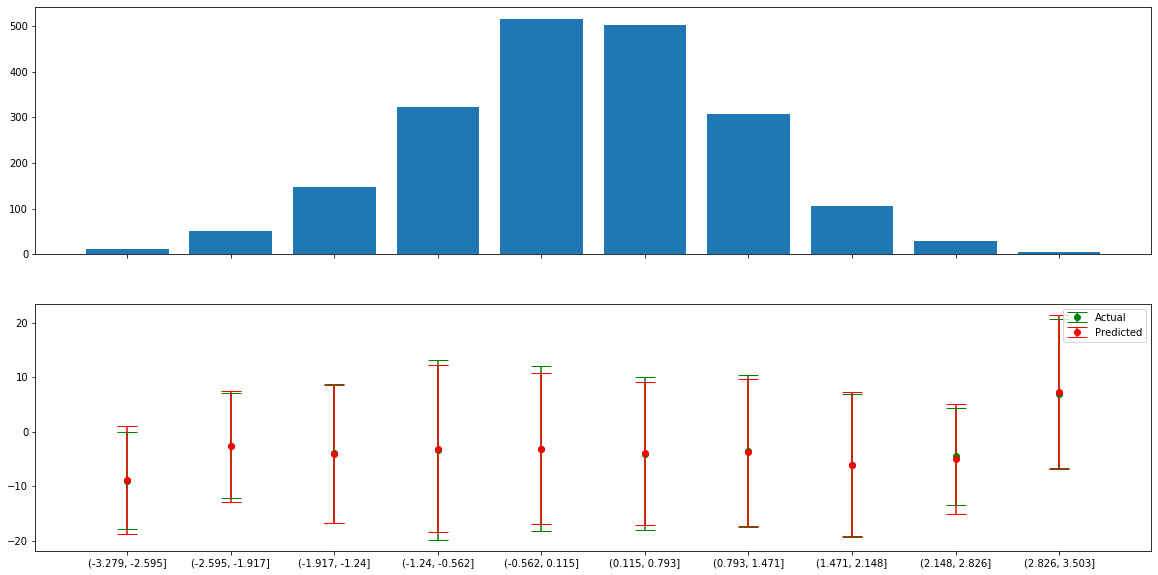

In [23]:
# x2
plot_univariate(df10, 'x2', 'y')

<ipython-input-21-aae3c8e7af56>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df10.x7 == filter_x7]


                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.271, -2.591]    5 -8.106606   8.415644 -4.577277   7.058366
1  (-2.591, -1.917]   24 -0.454520  10.475494  2.106401   9.997446
2  (-1.917, -1.243]   66  5.468557   9.691468  5.900804   9.047827
3  (-1.243, -0.569]  143  7.990921  12.138608  7.855556  10.219910
4   (-0.569, 0.105]  245  7.707951  12.060639  6.807718  10.861414
5    (0.105, 0.778]  226  7.482381   9.601512  6.478605   9.000973
6    (0.778, 1.452]  157  5.186901  10.571099  4.921974   9.588582
7    (1.452, 2.126]   53  2.455858  10.313153  3.140891   9.659800
8      (2.126, 2.8]    9 -5.622920   6.225904 -2.048294   6.894958
9      (2.8, 3.474]    3  4.351880  11.060596  7.135297  10.869113


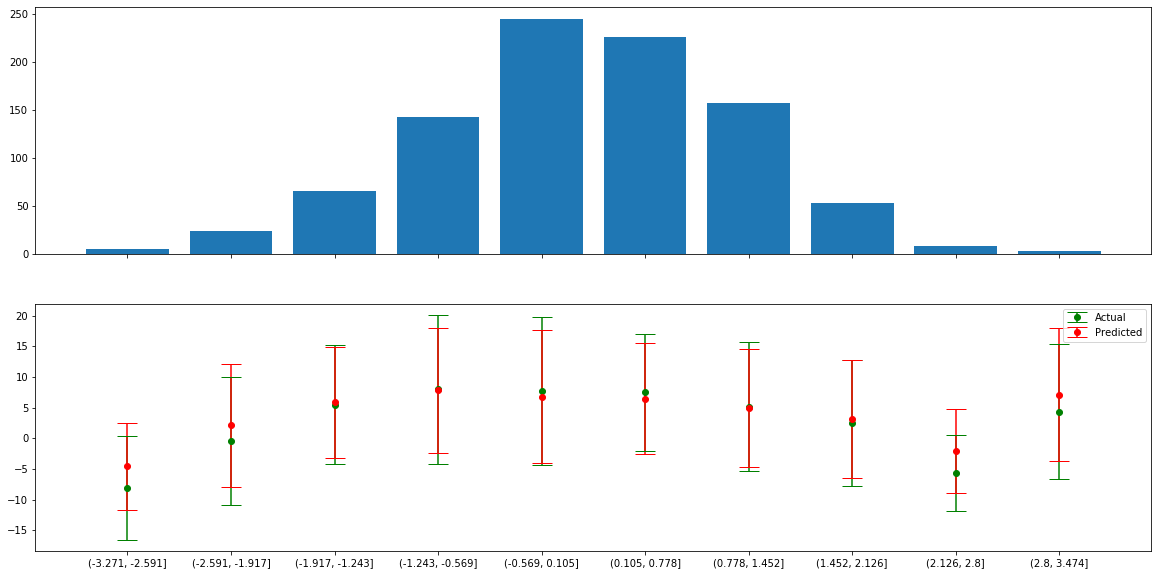

In [24]:
# x2 * x7 == A1
plot_univariate(df10, 'x2', 'y', filter_x7='A1')

<ipython-input-21-aae3c8e7af56>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df10.x7 == filter_x7]


                 x2    n     y_mean       y_sd     p_mean       p_sd
0  (-3.279, -2.595]    6  -9.676958  10.048865 -12.470871  11.191236
1  (-2.595, -1.917]   27  -4.475799   8.623015  -6.995727   8.337629
2   (-1.917, -1.24]   82 -11.520478   9.449803 -12.081397   8.986869
3   (-1.24, -0.562]  178 -12.621042  13.489726 -12.118688  12.563336
4   (-0.562, 0.115]  269 -13.150621   9.761618 -12.389801   8.971748
5    (0.115, 0.793]  279 -12.984273  10.235272 -12.108241   9.738740
6    (0.793, 1.471]  148 -13.208319  10.359310 -13.348078  10.070436
7    (1.471, 2.148]   57 -12.820662  11.315906 -13.469252  11.283851
8    (2.148, 2.826]   20  -4.009443   9.949655  -6.228494  11.147831
9    (2.826, 3.503]    3   9.621860  17.947949   7.520540  19.434831


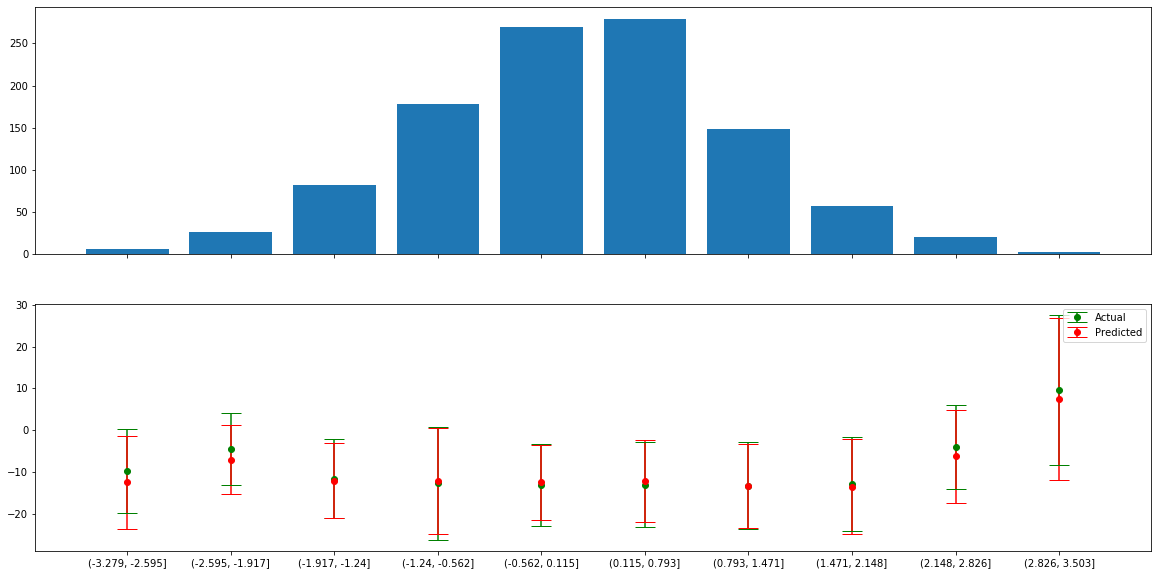

In [25]:
# x2 * x7 == A2
plot_univariate(df10, 'x2', 'y', filter_x7='A2')

                x3    n     y_mean       y_sd     p_mean       p_sd
0  (-0.323, 0.366]    9 -11.805981  10.815292 -10.317243  10.764086
1   (0.366, 1.048]   43  -0.902139  16.096326  -1.531529  15.621301
2    (1.048, 1.73]  165  -4.245541  13.734647  -4.399199  13.236572
3    (1.73, 2.412]  362  -2.600431  14.504536  -2.464310  13.465721
4   (2.412, 3.094]  530  -4.319000  14.038637  -4.173901  13.260953
5   (3.094, 3.776]  462  -3.946593  14.129089  -4.104081  13.484870
6   (3.776, 4.458]  288  -2.848500  15.211305  -2.986631  13.857547
7    (4.458, 5.14]  113  -3.893005  16.089874  -4.100243  15.175697
8    (5.14, 5.822]   25  -5.653557  14.065525  -4.743391  12.724448
9   (5.822, 6.504]    3  -9.220591  19.771726  -8.718256  18.020923


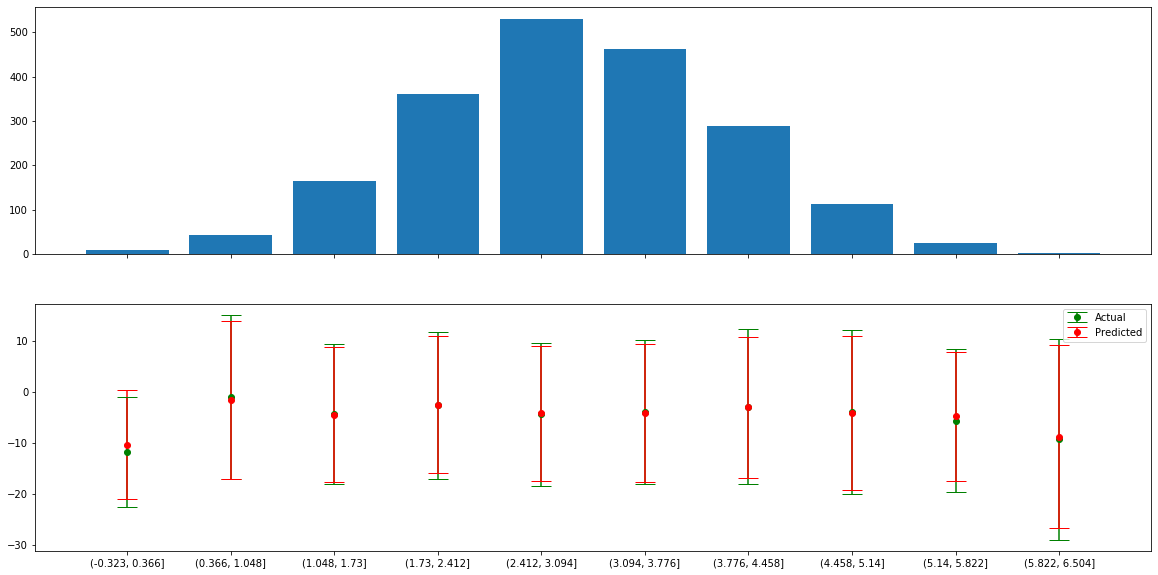

In [26]:
# x3
plot_univariate(df10, 'x3', 'y')

                 x4    n     y_mean       y_sd     p_mean       p_sd
0  (-3.336, -2.646]    6 -10.930331  12.006297 -12.564523  13.973415
1  (-2.646, -1.964]   37  -5.186150  19.615593  -5.130619  18.078145
2  (-1.964, -1.281]  136  -6.879913  13.236798  -6.641158  12.700757
3  (-1.281, -0.598]  358  -5.059908  15.377327  -4.884628  14.641840
4  (-0.598, 0.0847]  511  -4.743645  13.660591  -4.737330  12.669892
5   (0.0847, 0.767]  508  -2.253742  14.386944  -2.342864  13.464504
6     (0.767, 1.45]  305  -1.745711  14.430397  -1.512769  13.498047
7     (1.45, 2.133]  108  -1.684101  13.362159  -2.626998  12.814857
8    (2.133, 2.816]   23  -0.794036  15.371043  -1.528996  14.581240
9    (2.816, 3.499]    8  -2.814282  15.805801  -5.598334  14.397097


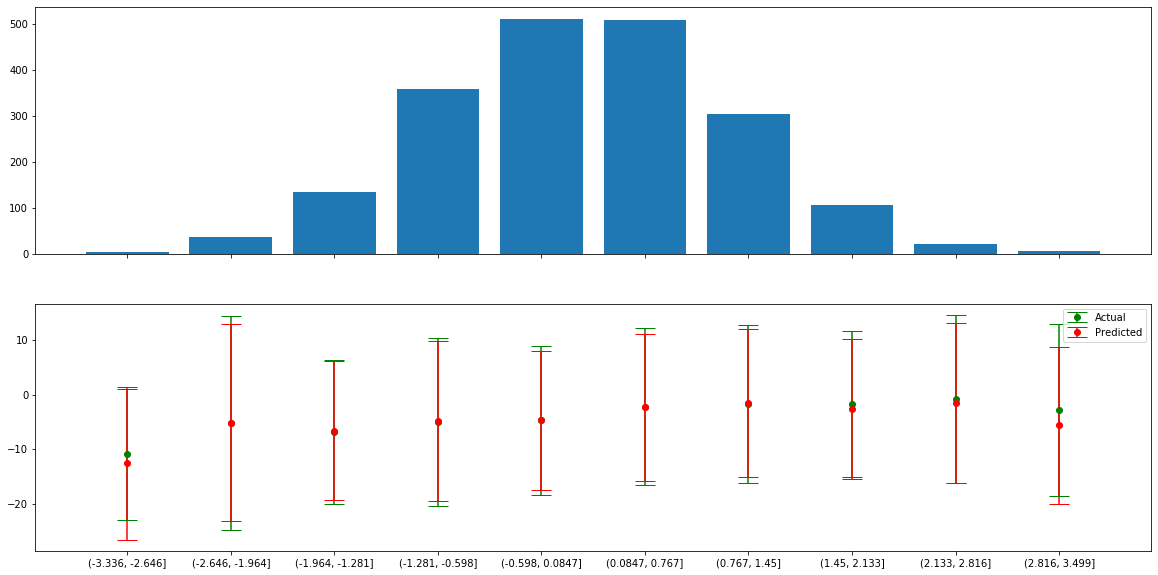

In [27]:
# x4
plot_univariate(df10, 'x4', 'y')

                 x5    n     y_mean       y_sd     p_mean       p_sd
0  (-3.852, -3.123]    2 -50.635420  13.284488 -33.205622  22.153181
1  (-3.123, -2.402]   19 -17.244148  13.685882 -16.398568  12.998512
2   (-2.402, -1.68]   89  -4.393372  12.563297  -3.763966  12.103042
3   (-1.68, -0.958]  215   0.895493  12.860241   0.018180  11.835497
4  (-0.958, -0.236]  502  -2.165445  13.036187  -2.438991  12.278219
5   (-0.236, 0.486]  558  -6.025738  13.261995  -5.955473  12.666892
6    (0.486, 1.207]  394  -7.183013  13.656944  -6.785776  12.882621
7    (1.207, 1.929]  177  -1.962756  15.046731  -2.114022  13.955202
8    (1.929, 2.651]   36  14.132880  15.216990  15.682202  13.186467
9    (2.651, 3.373]    8  52.118193  18.582697  48.335697  15.479677


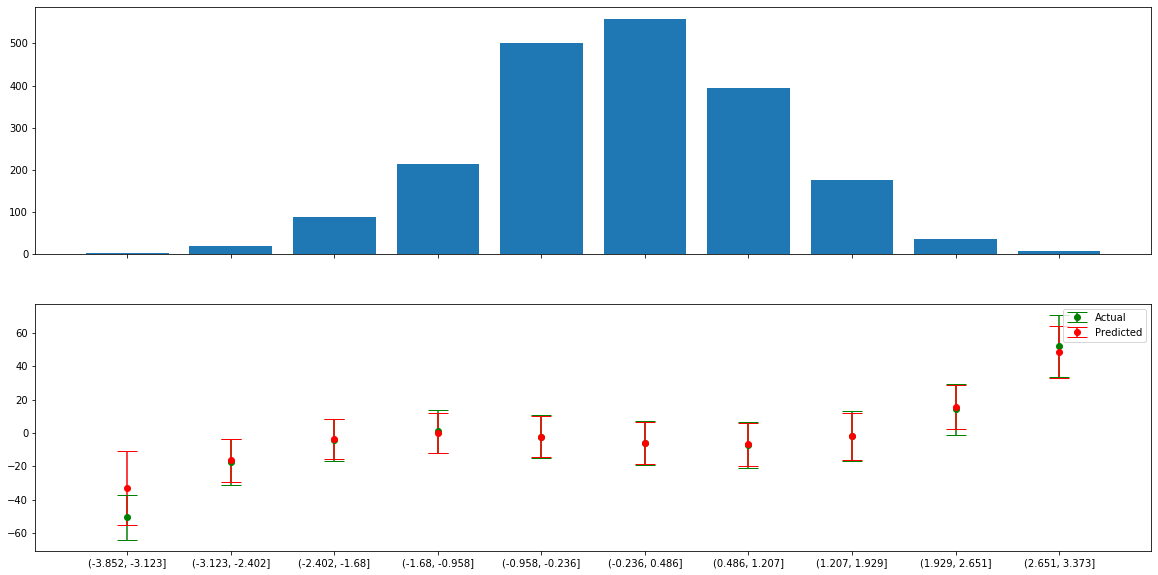

In [28]:
# x5
plot_univariate(df10, 'x5', 'y')

                 x6    n     y_mean       y_sd     p_mean       p_sd
0   (-0.968, 0.459]    6 -14.542230   4.385183 -12.331048   5.889802
1    (0.459, 1.871]   34   1.585852  15.082694   0.986782  14.601042
2    (1.871, 3.284]  146  -4.745006  14.198404  -5.144856  13.748450
3    (3.284, 4.697]  358  -3.081514  14.421713  -2.893038  13.489596
4    (4.697, 6.109]  523  -3.785036  14.272484  -3.703559  13.363623
5    (6.109, 7.522]  494  -4.211936  13.714992  -4.189745  13.096624
6    (7.522, 8.934]  298  -3.055536  15.420581  -3.298907  14.157809
7   (8.934, 10.347]  114  -3.306535  16.295409  -3.555499  15.306594
8  (10.347, 11.759]   24  -5.302985  13.386852  -4.497070  12.216284
9  (11.759, 13.172]    3  -8.088833  18.924234  -7.603382  17.247820


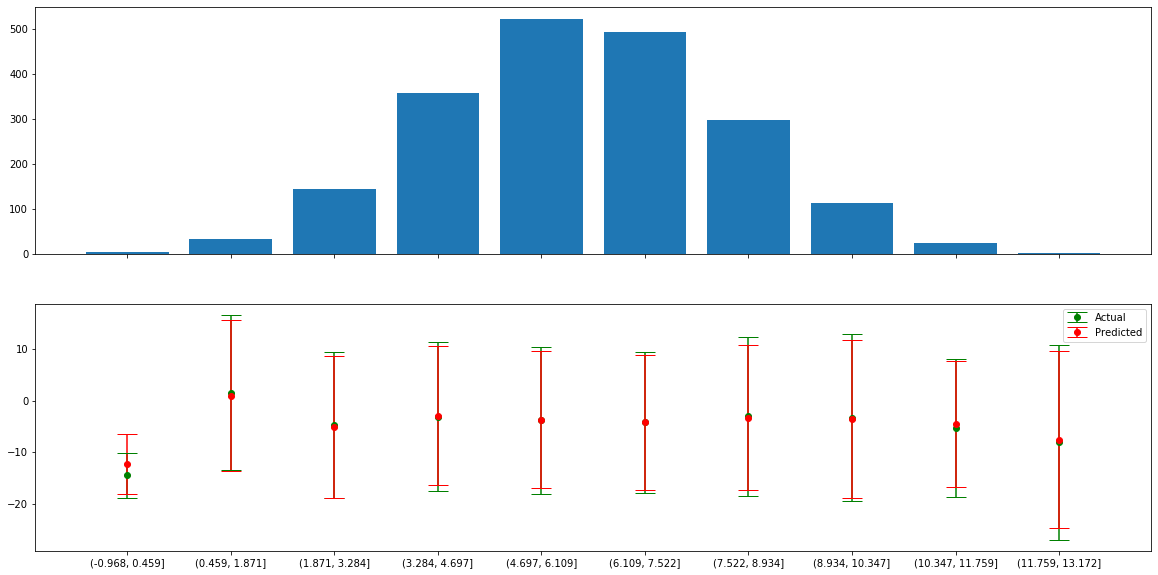

In [29]:
# x6
plot_univariate(df10, 'x6', 'y')

   x7     n     y_mean       y_sd     p_mean       p_sd
0  A1   931   6.378737  11.131655   6.030837   9.962587
1  A2  1069 -12.410846  10.906534 -12.130812  10.282227


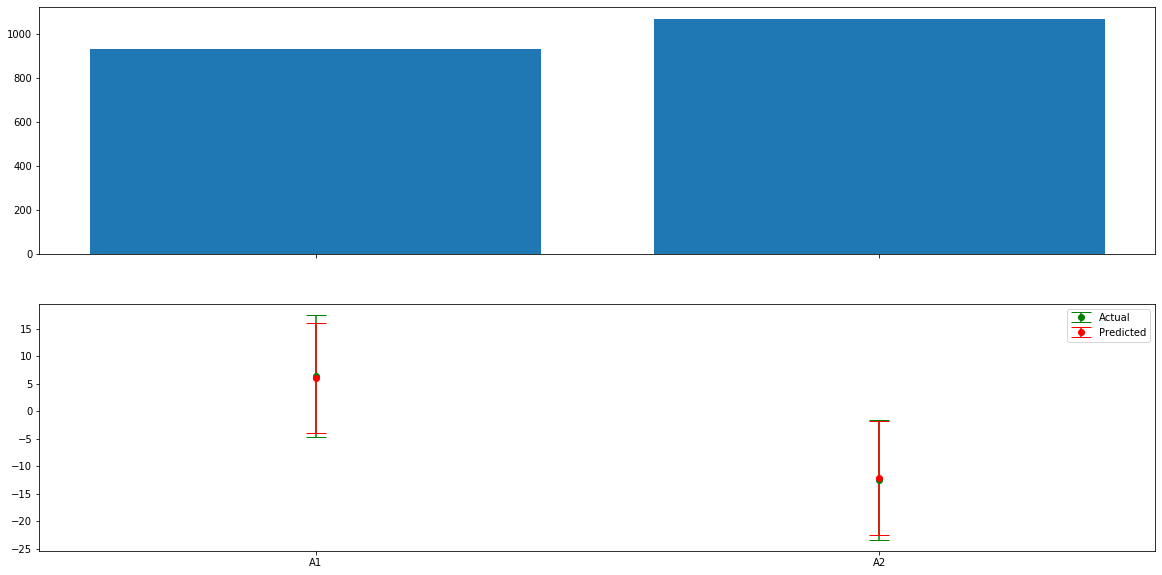

In [30]:
# x7
plot_univariate(df10, 'x7', 'y')

   x8    n    y_mean       y_sd    p_mean       p_sd
0  B1  408 -9.870796  14.827481 -9.558853  13.865532
1  B2  384 -9.155140  13.449646 -9.010555  12.492406
2  B3  439  0.319236  13.723353  0.086674  12.837350
3  B4  365 -0.198614  13.249155 -0.270108  12.432604
4  B5  404  0.362915  12.953490  0.167020  12.346337


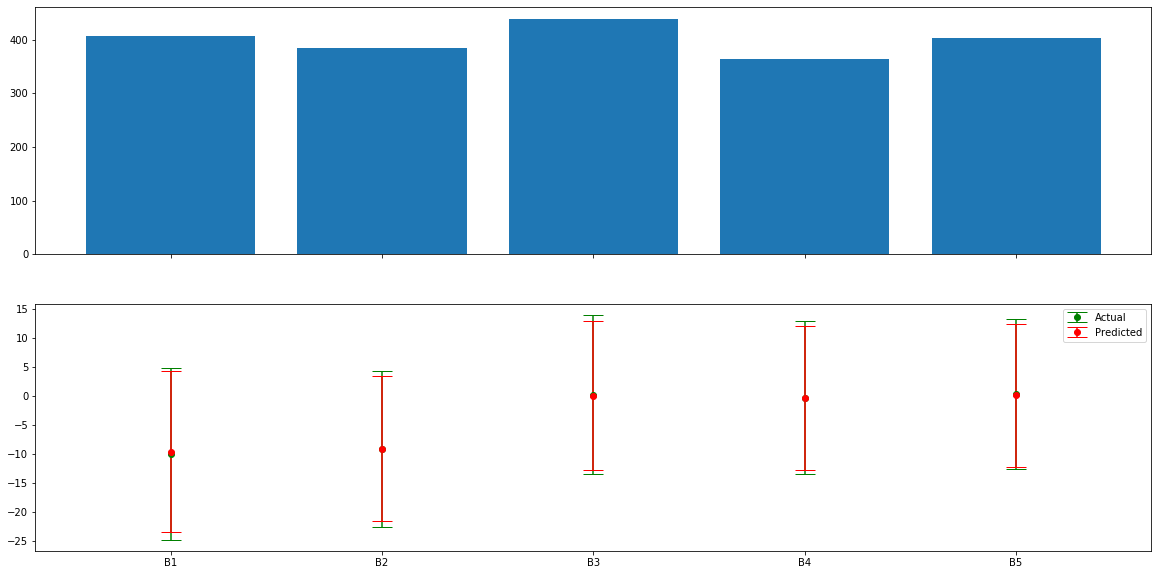

In [31]:
# x8
plot_univariate(df10, 'x8', 'y')

     x9   n     y_mean       y_sd     p_mean       p_sd
0    C0  44 -11.449154  11.865423 -12.832936  11.138705
1    C1  39  -7.403877  11.560906  -8.198854  10.807495
2   C10  41  -8.399086  15.627309  -7.621894  14.788294
3   C11  41  -8.086080  12.148196  -8.626845  12.049628
4   C12  42  -8.241409  12.543559  -8.582386  11.330741
5   C13  48  -2.180046  14.542123  -0.976496  11.864689
6   C14  44   3.727839  12.759579   3.689955  12.080002
7   C15  43 -12.738585  11.075329 -12.621274  11.097161
8   C16  47  -9.826713  11.958178 -10.529575  11.171875
9   C17  47  -3.939025  12.629985  -4.807873  11.447767
10  C18  51  -3.557728  10.818493  -2.535203  10.558583
11  C19  35   7.096602  12.006954   7.015767  11.248909
12   C2  34  -2.137282  12.039587  -3.143877  11.181596
13  C20  40 -11.236139  12.753242 -11.816540  12.823951
14  C21  34  -7.729983  14.700335  -8.114359  14.759360
15  C22  30  -8.004749  11.753302  -8.208667  11.003565
16  C23  25  -1.158287  11.773694  -0.908927  10

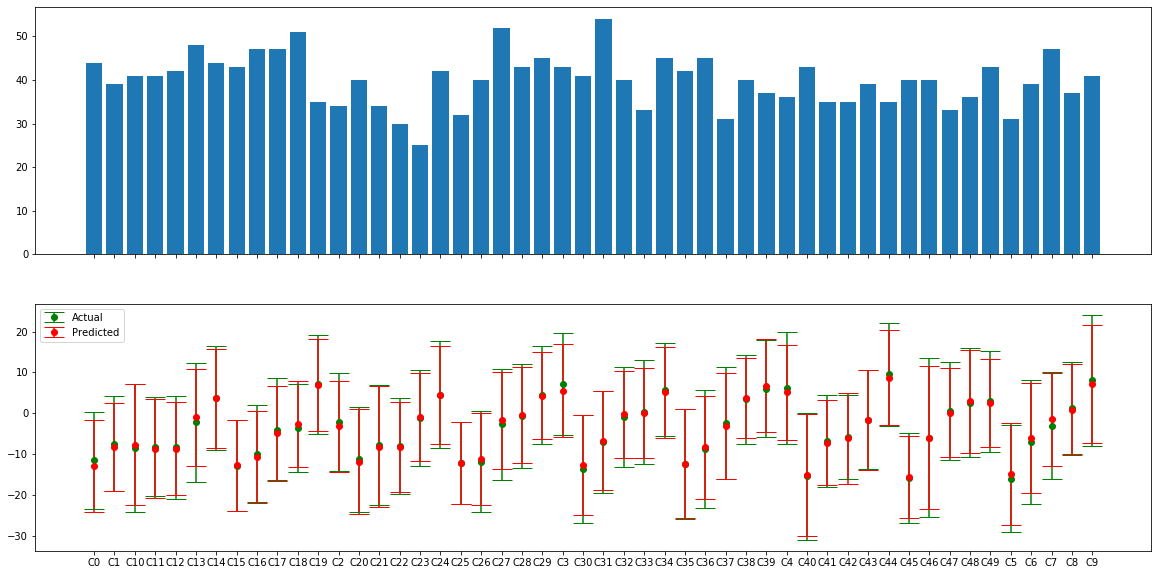

In [32]:
# x9
plot_univariate(df10, 'x9', 'y')

  x10    n    y_mean       y_sd    p_mean       p_sd
0  D1  421  0.256379  13.741910  0.011397  12.863994
1  D2  826 -0.427810  13.260177 -0.428542  12.470163
2  D3  753 -9.406580  14.293531 -9.301397  13.313836


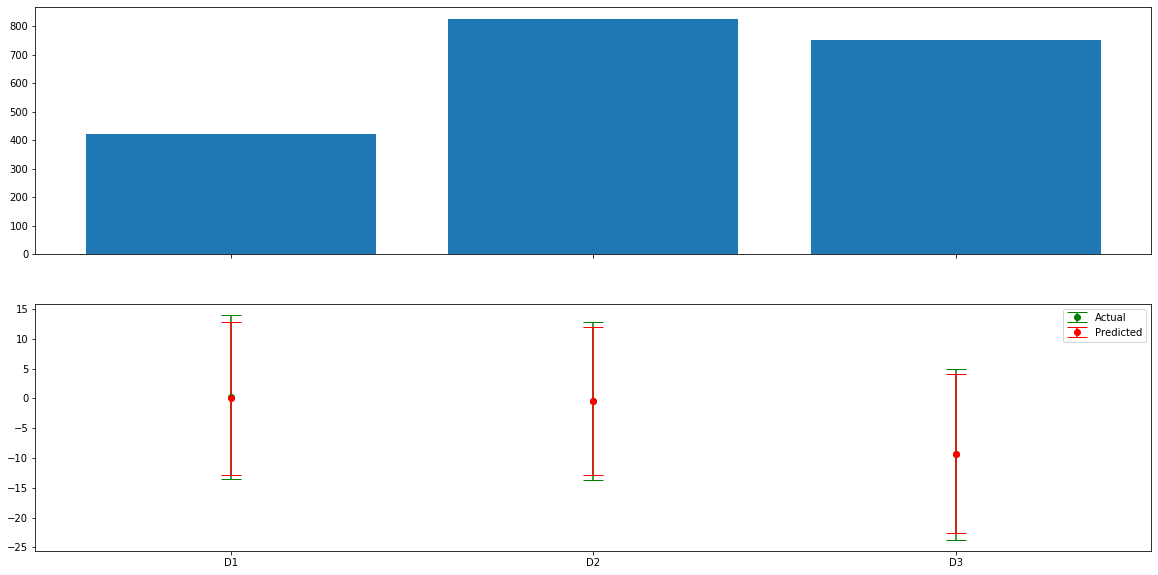

In [33]:
# x10
plot_univariate(df10, 'x10', 'y')

The only thing that really sticks out is relatively extreme x5 values, but we'd be affected ~10 rows by doing anything.  So let's leave the model as is.

# Evaluate on holdout

Let's evaluate all of our "best" hyperparameter sets to see how the holdout results compare to train/test results.

In [34]:
# Refit models on train and test data together
models_traintest = {}

for hp in best_hp_sets:
    print(f'Fitting {hp}')
    
    # Get train+test data
    X = X_train.append(X_test)
    y = y_train.append(y_test)
    
    # Fit gbm
    gbm = GradientBoostingRegressor(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = hp[0],
        max_features = hp[1],
        subsample = hp[2],
        # Print status
        verbose = 1
    ).fit(X, y)
    
    # Save predictions
    models_traintest[hp] = {
        'model': gbm,
        'err': y - gbm.predict(X),
        'holdout_err': y_holdout - gbm.predict(X_holdout)
    }
    
    del X, y, gbm

Fitting (3, 'auto', 0.5)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         185.6021          26.3758            5.99s
         2         164.2667          22.0185            6.49s
         3         142.9581          18.0369            6.65s
         4         122.2121          15.7537            6.72s
         5         107.4169          13.1402            6.77s
         6         100.6832          10.7196            6.63s
         7          93.3017           8.9085            6.67s
         8          82.8316           7.6082            6.70s
         9          78.5671           6.3188            6.61s
        10          71.1476           5.8965            6.63s
        20          41.9048           1.5380            6.32s
        30          29.0225           1.0296            6.21s
        40          20.5329           0.7775            6.14s
        50          15.4417           0.3207            6.06s
        60          13.6697           0.1474

In [35]:
# Create df of train, test, train+test, and holdout performance for each best hyperparameter space
all_performance = dict()
for hp in best_hp_sets:
    all_performance[hp] = [
        amse(models_train_2[hp]['train_err']),
        amse(models_train_2[hp]['test_err']),
        amse(models_traintest[hp]['err']),
        amse(models_traintest[hp]['holdout_err']),
    ]
    
all_performance_df = pd.DataFrame.from_dict(
    all_performance,
    orient='index',
    columns=['train', 'test', 'train+test', 'holdout']
).reset_index()

all_performance_df

,index,train,test,train+test,holdout
0,"(3, auto, 0.5)",8.703521,10.829725,8.989635,12.461160
1,"(4, auto, 0.75)",7.521834,10.940467,7.222175,10.421275
2,"(2, auto, 0.75)",10.411193,11.864202,9.456520,11.249991
3,"(6, auto, 0.5)",8.407073,12.291085,7.054994,12.057749
4,"(4, log2, 0.5)",9.471612,12.918625,8.367248,13.132174
5,"(3, sqrt, 0.75)",9.942242,12.563745,9.266201,14.100427


In [36]:
# Melt for proper group bargraphing
all_performance_df_melt = pd.melt(all_performance_df, id_vars='index')

all_performance_df_melt

,index,variable,value
0,"(3, auto, 0.5)",train,8.703521
1,"(4, auto, 0.75)",train,7.521834
2,"(2, auto, 0.75)",train,10.411193
3,"(6, auto, 0.5)",train,8.407073
4,"(4, log2, 0.5)",train,9.471612
5,"(3, sqrt, 0.75)",train,9.942242
6,"(3, auto, 0.5)",test,10.829725
7,"(4, auto, 0.75)",test,10.940467
8,"(2, auto, 0.75)",test,11.864202
9,"(6, auto, 0.5)",test,12.291085


Text(0, 0.5, 'AMSE')

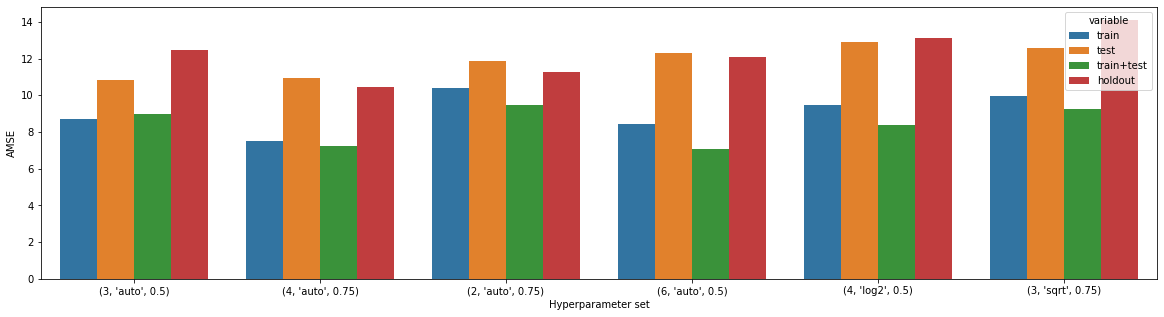

In [37]:
# Plot
plt.figure(figsize=(20, 5))
sb.barplot(
    data=all_performance_df_melt,
    x='index',
    y='value',
    hue='variable',
)
plt.xlabel('Hyperparameter set')
plt.ylabel('AMSE')

Text(0, 0.5, 'AMSE')

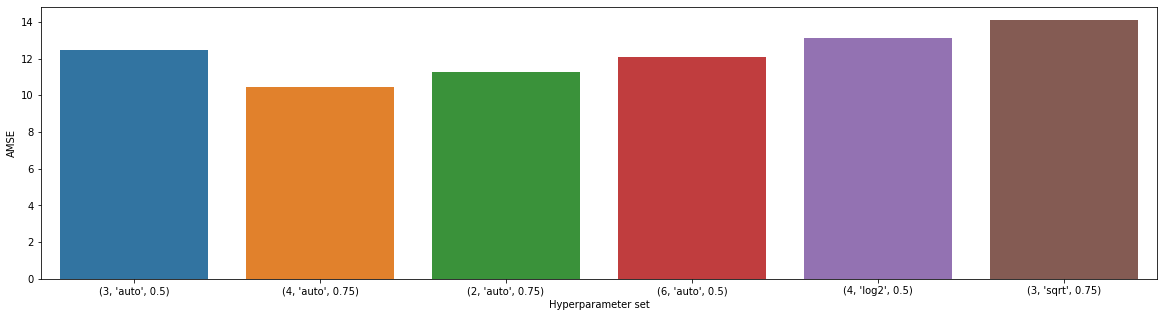

In [38]:
# Plot just holdout performance
plt.figure(figsize=(20, 5))
sb.barplot(
    data=all_performance_df_melt[all_performance_df_melt.variable == 'holdout'],
    x='index',
    y='value',
)
plt.xlabel('Hyperparameter set')
plt.ylabel('AMSE')

(4, auto, 0.75) seems like the best all-around fit:

- Second best performance on the test data (though incredibly close to the best) and best performance on the holdout data
    - There's a lot of room for muddiness in picking between models that seem to be performing similarly, so "average" performance across test/holdout is something I usually use in making final decisions on which model to use
    - But, sometimes, the best thing to do is run multiple models in parallel in a "staging" type setup to see how they perform on new data and then make a final decision
- Similar performance on holdout set compared to test set
    - I generally index highly on having similar result in test/holdout unless there is a good reason for them to be different

Some other notes:

- (6, auto, 0.5) had the best performances on train-only and train/test-only data but worse performance on test and holdout (i.e. overfitting!)
    - As stated previously in the notebook, this is likely due to not having any sort of regularization (e.g. pruning, requiring a certain sample size) to balance tree complexity with accuracy
- The 'sqrt' and 'log' models don't do as well (they usually do right out of the box)
    - This is likely due to us restricting to only strong predictors at the outset, so when we sample those predictors we are excluding information that would likely be helpful